In [ ]:
# Imports
# Data wrangling, cleaning, storage
import pandas as pd
# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# Data splitting and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
# Model
from sklearn.ensemble import RandomForestClassifier
# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report)

In [2]:
# Load JSON file into DataFrames
logins_df = pd.read_json("logins.json")

# Quick look at the DataFrames
print("Logins DataFrame:")
print(logins_df.head())
print(logins_df.shape)

Logins DataFrame:
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
(93142, 1)


PART 1: Exploratory data analysis

In [3]:
# Convert logins_df login_time to date time formant
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
# Reset Date time column to index
logins_df = logins_df.set_index('login_time')  

In [4]:
# Count logins per 15 minute interval using resample function
logins_15min = logins_df.resample('15min').size().rename('logins')

In [5]:
# Inspect head and decribe data
print(logins_15min.head())
print(logins_15min.describe())

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, Name: logins, dtype: int64
count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: logins, dtype: float64


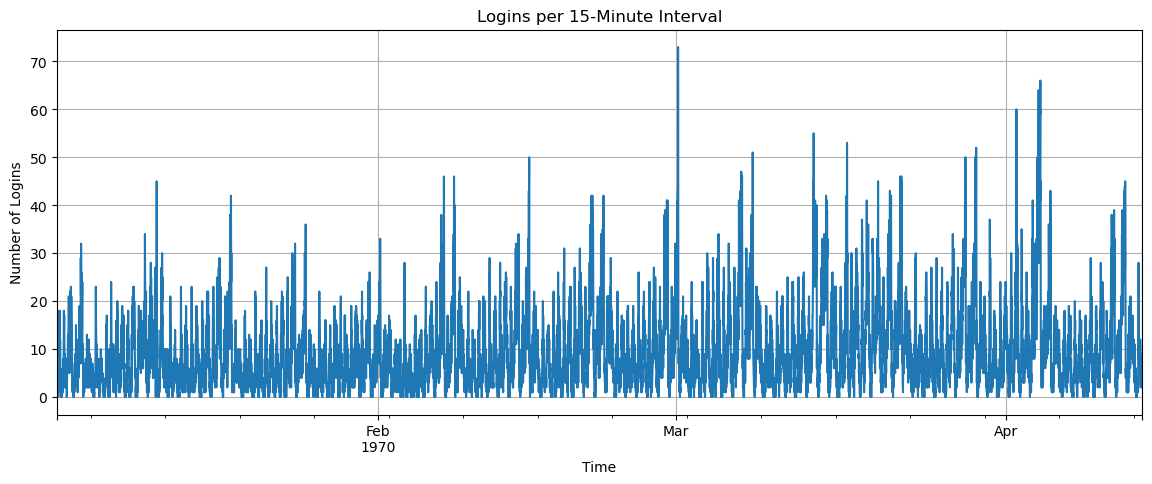

In [6]:
# Visualize logintime data
logins_15min.plot(figsize=(14,5), title='Logins per 15-Minute Interval')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.grid(True)
plt.show()

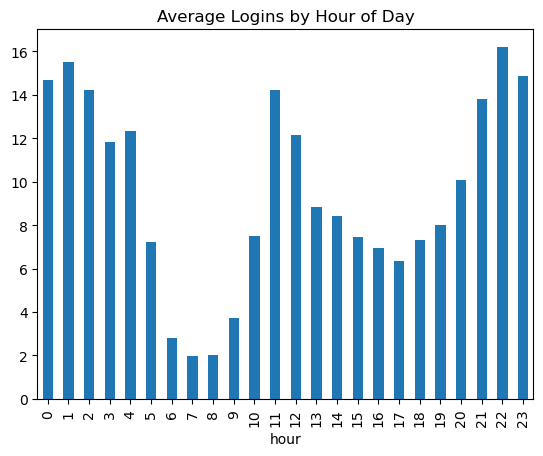

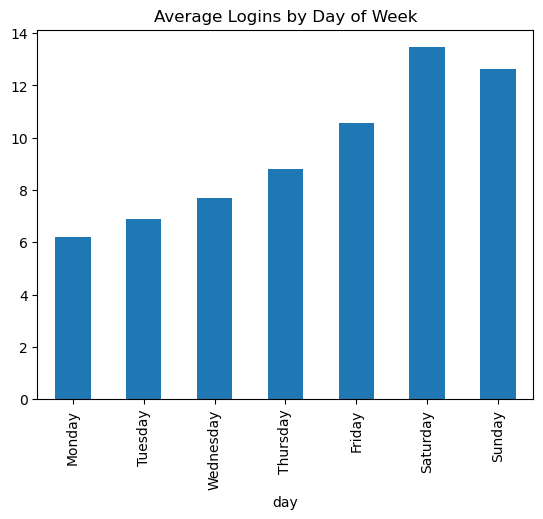

In [7]:
# Create Weekly and Daily averages to see login trends based on hour of day, or day of week
# Create hour and day columns
logins_15min = logins_15min.reset_index()
logins_15min['hour'] = logins_15min['login_time'].dt.hour
logins_15min['day'] = logins_15min['login_time'].dt.day_name()

# Average logins by hour
avg_by_hour = logins_15min.groupby('hour')['logins'].mean()
avg_by_hour.plot(kind='bar', title='Average Logins by Hour of Day')
plt.show()

# Average logins by day of week
avg_by_day = logins_15min.groupby('day')['logins'].mean()
# Reorder days for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_by_day = avg_by_day.reindex(days_order)
avg_by_day.plot(kind='bar', title='Average Logins by Day of Week')
plt.show()

Logins tend to rise throughout the week, peaking on Saturday and Sunday, and resetting on Monday. Peak times occur during lunch hours, 11-12, and late night/early morning, 10pm to 4am, with the lowest logins recorded from the hours of 6-9am.

The outlier maxmimum login window at 73 logins does fall onto a sunday at 4:30 am, both relativley busy times, rest of the data looks normal so can assume this is a outlier but plausibly correct data.

PART 2: Experiment and metrics design

1. Key measures of success

Key measure of success should be proportion of driver partners who serve both Gotham and Metropolis during the expermient. It follows that the issue being driver exclusivity to a city, the goal should be to increase drivers who are availble in both city.

2. Practical Expermient

A. A randomized controlled trial could be conducted, randomly dividing the drivers into 2 groups: A trial group who are offered full reimbursments on tolls, and a control group who continue driving as normally without reimbursment. Run the experiment for at least 2 full weeks, ideally longer to capture temporal changes in driver behavior. Keep track of how many times drivers cross the toll between Gotham and Metropolis.

Null Hypothesis: Toll reimbursment does NOT increase the proportion of drivers serving both cities

Alternative Hypothesis: Toll reimburment increases the proportion of drivers serving both cities

B. A two proportion z-test can be used to test the difference in proportions between independent populations, in this case, our test group and control group drivers.

C. We conduct a one sided statistical test with a significane level of 0.05. p-value represents probability of observing the data or something more extreme assuming the null hypothesis is true. If p-value is less than 0.05 we reject null hypothesis and conclude toll reimubsrment siginficantly increases the proportion of cross-city drivers.




PART 3: Predictive Modeling

In [8]:
# Load json file into pandas dataframe ultimate_df
ultimate_df = pd.read_json("ultimate_data_challenge.json")

# Print head and shape of dataframe
print("Ultimate Data Challenge DataFrame:")
print(ultimate_df.head())
print(ultimate_df.shape)

Ultimate Data Challenge DataFrame:
             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0       

In [9]:
# Look at head of data
print(ultimate_df.head(10))

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   
5      Winterfell                       2  2014-01-09                   3.5   
6         Astapor                       1  2014-01-24                   NaN   
7      Winterfell                       2  2014-01-28                   5.0   
8      Winterfell                       2  2014-01-21                   4.5   
9      Winterfell                       1  2014-01-03                   NaN   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4           

In [10]:
# Describe numerical stats
print(ultimate_df.describe())

       trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          49799.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.446652  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.00000

In [11]:
# COunt catagorical values
print(ultimate_df['city'].value_counts())
print(ultimate_df['phone'].value_counts())
print(ultimate_df['ultimate_black_user'].value_counts())

city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64
phone
iPhone     34582
Android    15022
Name: count, dtype: int64
ultimate_black_user
False    31146
True     18854
Name: count, dtype: int64


In [12]:
# Convert dates
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

# Use extraction date as a proxy for a cutoff date to determing retention in last 30 days
# Define dataset extraction date
dataset_date = ultimate_df['last_trip_date'].max()

# Create retention target
ultimate_df['retained'] = (dataset_date - ultimate_df['last_trip_date']).dt.days <= 30

# Retention rate
retention_rate = ultimate_df['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")

Retention rate: 37.61%


In [13]:
# Check for missing values
print(ultimate_df.isnull().sum())

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64


Ratings missing is not a huge deal, likely not descript trips between driver and passanger, can safley impute these with the median rating.

In [14]:
# Impute median ratings for missing rows
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].median())
ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].median())

In [15]:
# Check if phoen type is correlated with retention rate
print(ultimate_df.groupby('phone')['retained'].mean())

phone
Android    0.209426
iPhone     0.448933
Name: retained, dtype: float64


In [16]:
# Drop missing phone rows account for less than 1% of data
# Drop rows where 'phone' is missing
ultimate_df = ultimate_df.dropna(subset=['phone'])

# Confirm no more missing phone values
print(ultimate_df['phone'].isnull().sum())

0


In [17]:
# Recheck for null values
print(ultimate_df.isnull().sum())

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
dtype: int64


In [18]:
# Check columns
ultimate_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained'],
      dtype='object')

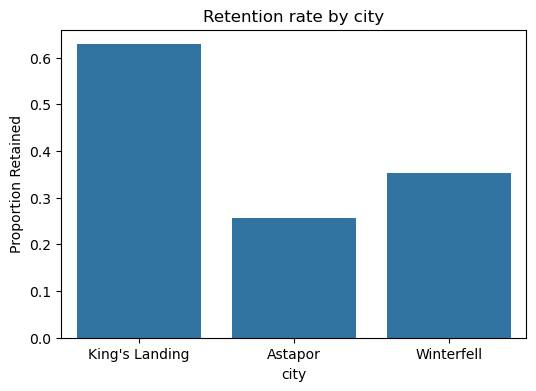

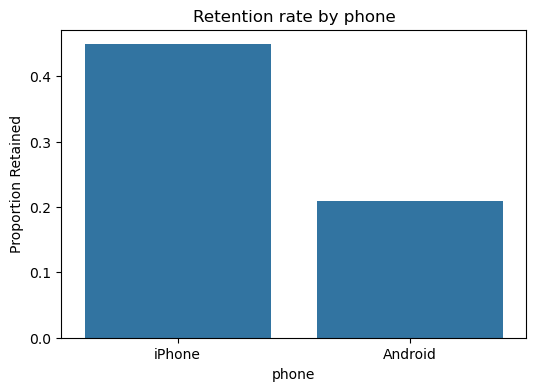

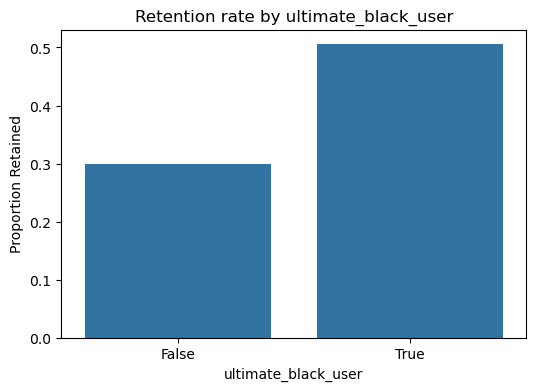

In [19]:
# Look at relationship between catagorical data and retention rates
categorical_cols = ['city', 'phone', 'ultimate_black_user']
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y='retained', data=ultimate_df, errorbar=None)
    plt.title(f'Retention rate by {col}')
    plt.ylabel('Proportion Retained')
    plt.xlabel(col)
    plt.xticks()
    plt.show()


In [20]:
# Look at correltion between retention and numeric data
numeric_cols = [
    'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
    'surge_pct', 'avg_surge', 'weekday_pct', 'trips_in_first_30_days', 'retained']

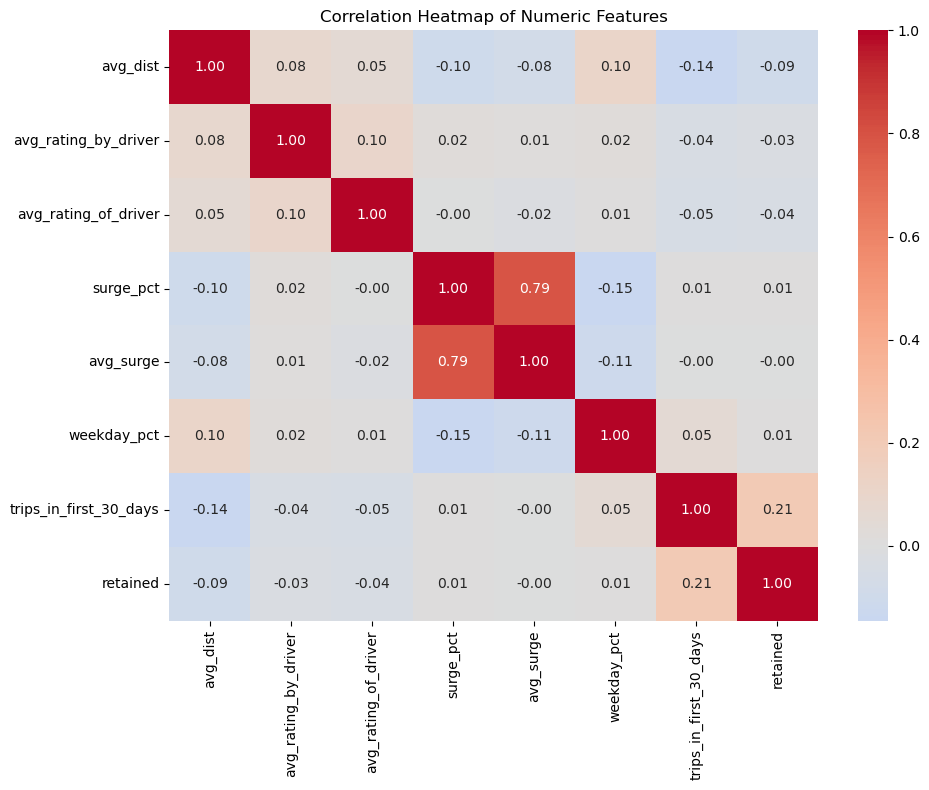

In [21]:
# Compute correlation matrix
corr_matrix = ultimate_df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering

# Convert bool columns to int
ultimate_df['ultimate_black_user'] = ultimate_df['ultimate_black_user'].astype(int)
ultimate_df['retained'] = ultimate_df['retained'].astype(int)

In [25]:
# Create days_since_signup feature
ultimate_df['days_since_signup'] = (dataset_date - ultimate_df['signup_date']).dt.days

In [27]:
# Map phone types to integers
phone_mapping = {'Android': 0, 'iPhone': 1}
ultimate_df['phone'] = ultimate_df['phone'].map(phone_mapping)

In [ ]:
# One-hot encode city column and join it back to the DataFrame
city_dummies = pd.get_dummies(ultimate_df['city'], prefix='city')

# Drop city column and add new encoded columns
ultimate_df = pd.concat([ultimate_df.drop('city', axis=1), city_dummies], axis=1)

In [35]:
# Drop datetime columns and save as new df 'df' for modelling
df = ultimate_df.drop(['signup_date', 'last_trip_date'], axis=1)

In [36]:
# Review data types
df.dtypes

trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                       int64
surge_pct                 float64
ultimate_black_user         int64
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                    int64
days_since_signup           int64
city_Astapor                 bool
city_King's Landing          bool
city_Winterfell              bool
dtype: object

In [39]:
# Modeling
# Separate features and target
X = df.drop('retained', axis=1)
y = df['retained']

# Split data: 80% train, 20% test, stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
# Train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

In [42]:
# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[5241  946]
 [1339 2395]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      6187
           1       0.72      0.64      0.68      3734

    accuracy                           0.77      9921
   macro avg       0.76      0.74      0.75      9921
weighted avg       0.77      0.77      0.77      9921

ROC AUC Score: 0.8338076304056512


                   Feature  Importance
7                 avg_dist    0.209765
9        days_since_signup    0.136318
6              weekday_pct    0.120672
8     avg_rating_by_driver    0.107788
4                surge_pct    0.077517
0   trips_in_first_30_days    0.073270
1     avg_rating_of_driver    0.072066
2                avg_surge    0.059104
11     city_King's Landing    0.046230
3                    phone    0.036898
5      ultimate_black_user    0.031919
10            city_Astapor    0.015998
12         city_Winterfell    0.012453


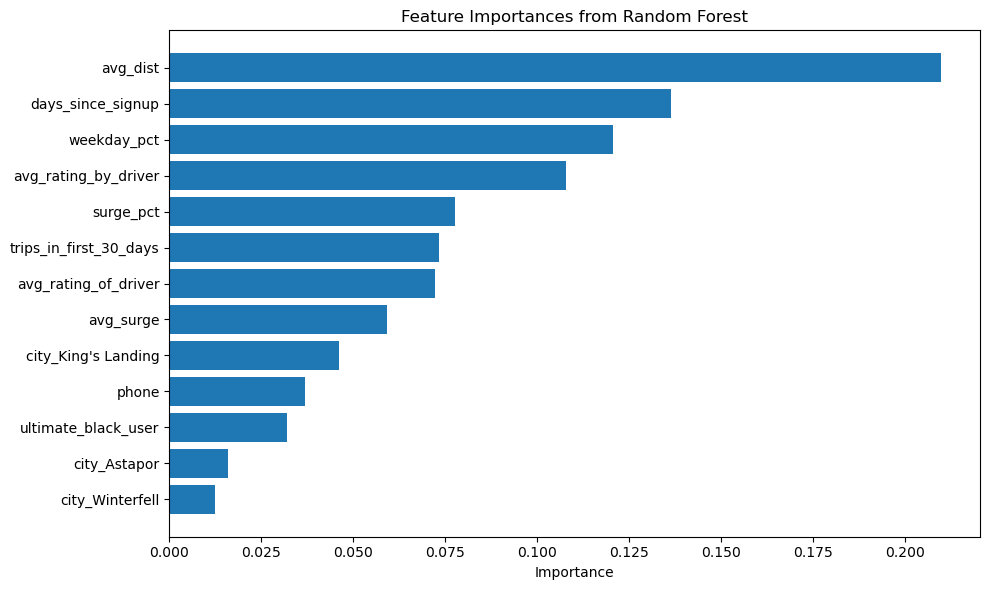

In [43]:
# Get feature importances from the fitted model
importances = rf.feature_importances_

# Match them to column names
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feat_imp_df)

# Optional: Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

1. After cleaning the data and handling missing values, I explored how retention relates to different features. The overall retention rate was about 37.6%. Categorical variables like phone type and city showed clear differences in retention, with iPhone users and the city of winterhold having higher retention rates. Trips in the first 30 days was the numerical feature that stood out with the largest positive correlation with retention.

2. To predict whether a user would be active in their sixth month on the platform, I chose to use a Random Forest Classifier. This model strikes a strong balance between performance and interpretability, and I have experience using it effectively in similar classification problems. Random Forests are ensemble models that reduce the risk of overfitting often seen in single decision trees by averaging the predictions of multiple trees trained on random subsets of data and features. While I considered simpler alternatives like a standalone decision tree for their transparency, I preferred the ensemble approach for its improved robustness and predictive accuracy. Additionally, Random Forests handle mixed feature types well, require minimal preprocessing, and offer valuable insights into feature importance — all of which make them a practical and reliable choice for this task.

    The Model appears to be reasonably valid given the evalution metrics. It achieves a ROC AUC score of 0.83, indiating strong oiverall ability to dicern retained and non retained users. The classification report and confusion matrix indicate it performs slightly better in prdicting non0retained users, which is to be expected as the majority of users are not retained. Rersults indicate model captures real signal, considering this is a relativley raw model with no tuning or iteration beyond the inital preproccessing and test model.

3. Ultimate can use this model to identify users likely to churn based on factors like trip distance, weekday usage, and early activity. They can then target these users with promotions or incentives to encourage more frequent and longer trips, improving overall retention.